<a href="https://colab.research.google.com/github/it21813702/ML_Assignment_1/blob/main/ML_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# first comment, test code

## Data Loading and Initial Exploration

In [1]:
# import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')


In [3]:
# load the dataset
df = pd.read_csv('Loan_default.csv')

# print some basic infor about the dataset
print("dataset shape:", df.shape)

# print the initial rows of the dataset, can specidy how many by including a num in the brackets
df.head()


dataset shape: (10780, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56.0,85994.0,50587.0,520.0,80.0,4.0,15.23,36.0,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0.0
1,HPSK72WA7R,69.0,50432.0,124440.0,458.0,15.0,1.0,4.81,60.0,0.68,Master's,Full-time,Married,No,No,Other,Yes,0.0
2,C1OZ6DPJ8Y,46.0,84208.0,129188.0,451.0,26.0,3.0,21.17,24.0,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1.0
3,V2KKSFM3UN,32.0,31713.0,44799.0,743.0,0.0,3.0,7.07,24.0,0.23,High School,Full-time,Married,No,No,Business,No,0.0
4,EY08JDHTZP,60.0,20437.0,9139.0,633.0,8.0,4.0,6.51,48.0,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0.0



Missing Values per column: 
LoanID            0
Age               1
Income            1
LoanAmount        1
CreditScore       1
MonthsEmployed    1
NumCreditLines    1
InterestRate      1
LoanTerm          1
DTIRatio          1
Education         1
EmploymentType    1
MaritalStatus     1
HasMortgage       1
HasDependents     1
LoanPurpose       1
HasCoSigner       1
Default           1
dtype: int64

Summary statistics:
                Age         Income     LoanAmount   CreditScore  \
count  10779.000000   10779.000000   10779.000000  10779.000000   
mean      43.540681   82932.641525  127822.158363    574.813062   
std       14.903241   39155.168051   70531.435181    157.835972   
min       18.000000   15000.000000    5005.000000    300.000000   
25%       31.000000   49116.000000   66886.500000    439.000000   
50%       43.000000   82959.000000  127397.000000    576.000000   
75%       56.000000  116853.500000  188957.000000    709.000000   
max       69.000000  149997.000000  24995

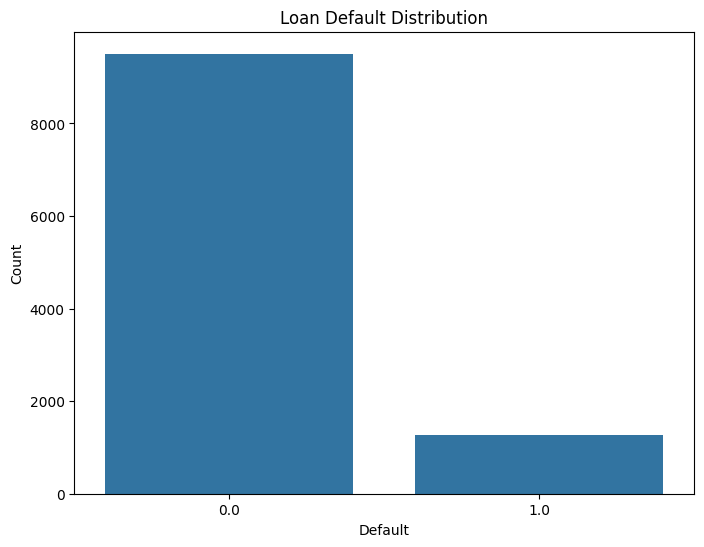

In [4]:
## further explore the dataset

# check for any missing values/nulls, etc..
print("\nMissing Values per column: ")
print(df.isnull().sum())

# get summary statistics
print("\nSummary statistics:")
print(df.describe())


# check the distribution of the target variable,(the loan default in this case)
print("\nTarget variable distribution:")
print(df['Default'].value_counts())
print(df['Default'].value_counts(normalize=True).round(4) * 100, "%")

# visualise the distribution of loan defaults
plt.figure(figsize=(8, 6))
sns.countplot(x='Default', data=df)
plt.title('Loan Default Distribution')
plt.ylabel('Count')
plt.show()


## Data Preprocessing and Cleaning

In [9]:
# identify the numerical and categorical features
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore',
                      'MonthsEmployed', 'NumCreditLines', 'InterestRate',
                      'LoanTerm', 'DTIRatio']

categorical_features = ['Education', 'EmploymentType', 'MaritalStatus',
                        'HasMortgage', 'HasDependents', 'LoanPurpose',
                        'HasCoSigner']


# check the categorical variables to understand their values
print("Examining categorical variables:")
for cat_feature in categorical_features:
    print(f"\n{cat_feature} value counts:")
    print(df[cat_feature].value_counts())

    print(f"Number of unique values: {df[cat_feature].nunique()}")


# identify and handle outliers in numerical features -- outliers affect logistic regression performance

# use IQR method to identify the outliers
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[ (df[column] < lower_bound) | (df[column] > upper_bound) ][column]

    return outliers.shape[0], lower_bound, upper_bound







Examining categorical variables:

Education value counts:
Education
Bachelor's     2747
PhD            2693
Master's       2677
High School    2662
Name: count, dtype: int64
Number of unique values: 4

EmploymentType value counts:
EmploymentType
Self-employed    2799
Unemployed       2676
Part-time        2658
Full-time        2646
Name: count, dtype: int64
Number of unique values: 4

MaritalStatus value counts:
MaritalStatus
Single      3638
Divorced    3582
Married     3559
Name: count, dtype: int64
Number of unique values: 3

HasMortgage value counts:
HasMortgage
No     5426
Yes    5353
Name: count, dtype: int64
Number of unique values: 2

HasDependents value counts:
HasDependents
No     5422
Yes    5357
Name: count, dtype: int64
Number of unique values: 2

LoanPurpose value counts:
LoanPurpose
Education    2175
Home         2169
Auto         2159
Other        2154
Business     2122
Name: count, dtype: int64
Number of unique values: 5

HasCoSigner value counts:
HasCoSigner
Yes    54